Training and running the ensemble

Importing necessary ilbraries

In [1]:
# Configuring for execution support
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Suppressing warnings
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Importing necessary packages
import tempfile
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scripts.ensemble_balanced_generator import BalancedDatasetGenerator
from scripts.ensemble_processed_generator import ProcessedDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument('--n_models', default=10, type=int, help='Number of models in the ensemble')
parser.add_argument('--model_name', default='ensemble_model', type=str, help='Name of the ensemble model')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=15, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/ensemble_model.png", help="Path to save model's plot")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr
N_MODELS=args.n_models
MODELS=['VGG16',
        'DenseNet121',
        'Xception',
        'VGG19',
        'MobileNet',
        'InceptionV3',
        'ResNet101V2',
        'DenseNet201',
        'ResNet50V2',
        'ResNet152V2']


Functions to load all method weights and creating the stacked model

In [3]:
# loading weights of all models
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # Defining the location of model
        filename = os.path.join(args.model_dir,MODELS[i]+'.h5')
        # Loading model from file
        model = load_model(filename)
        # Making all model layers non-trainable
        for layer in model.layers:
            layer.trainable = False
            # Renaming to avoid 'unique layer name' issue
            layer._name = MODELS[i] + '_' + layer.name
        # Adding to the list of all models
        all_models.append(model)
        print('[INFO] Loaded: {}'.format(MODELS[i]))
    print('[INFO] Loaded all models')
    return all_models

def create_model(members):  
    # Defining ensemble inputs
    ensemble_inputs = [model.input for model in members]
    # Merging outputs of each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    # Adding layers to be trained
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model([ensemble_inputs,output])
    # Plotting the ensemble model
    #plot_model(model, show_shapes=True, to_file=args.model_plot)
    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    #model.summary()
    return model


Reading the COVIDx dataset files and creating generators to load data

In [4]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

test_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation = False,
        data_files=df_test.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
)


def get_generators(df_trn, df_val):
    trn_generator = BalancedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        class_weights = [1.,1.,6.]
    )

    val_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation=True,
        data_files=df_val.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
    )

    return trn_generator, val_generator

Functions to fit and predict using stacked model

In [5]:
# Function to fit the model
def fit_stacked_model(model):
    X_train, X_test, _, _ = train_test_split(df_train, df_train['class'], test_size=0.33, random_state=42)
    
    # Getting generators
    train_generator, validation_generator = get_generators(X_train, X_test)
    
    # CREATE CALLBACKS
    checkpoint = ModelCheckpoint(args.model_dir+args.model_name, 
                            monitor='val_auc', verbose=1, 
                            save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=2)
    callbacks_list = [checkpoint, es]

    # Training model
    print("[INFO] Training the stacked model")
    H = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=EPOCHS,
        callbacks=callbacks_list,
        use_multiprocessing=True, workers=8)
    
    # Plotting training loss and accuracy
    N = len(H.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on COVIDx")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(args.plot)
    
    return model

def predict_stacked_model(model, test_generator):
    return model.predict(test_generator, steps=len(test_generator), verbose=1)

Training the model and predicting

In [6]:
# Training the model
members = load_all_models(args.n_models)


[INFO] Loaded: VGG16
[INFO] Loaded: DenseNet121
[INFO] Loaded: Xception
[INFO] Loaded: VGG19
[INFO] Loaded: MobileNet
[INFO] Loaded: InceptionV3
[INFO] Loaded: ResNet101V2
[INFO] Loaded: DenseNet201
[INFO] Loaded: ResNet50V2
[INFO] Loaded: ResNet152V2
[INFO] Loaded all models


In [7]:
pred=[]
for mem in members:
    p=predict_stacked_model(mem, test_generator)
    pred.append(p)
    
# sum across ensemble members
summed = np.sum(pred, axis=0)
# argmax across classes
result = np.argmax(summed, axis=1)


1579/1579 [==============================] - 55s 35ms/step


In [8]:
# Getting class label map
temp = []
for i in test_labels:
    temp.append(test_generator.mapping.get(i))

print(classification_report(temp, result, target_names=test_generator.mapping))

              precision    recall  f1-score   support

      normal       0.91      0.94      0.92       885
   pneumonia       0.89      0.86      0.88       594
    COVID-19       0.89      0.79      0.84       100

    accuracy                           0.90      1579
   macro avg       0.90      0.86      0.88      1579
weighted avg       0.90      0.90      0.90      1579



In [9]:
'''
Function to plot confusion matrix
Citation: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
'''
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[833  50   2]
 [ 75 511   8]
 [ 10  11  79]]
Overall Accuracy: 0.9012
COVID Sensitivity: 0.9412
COVID Specificity: 0.8775


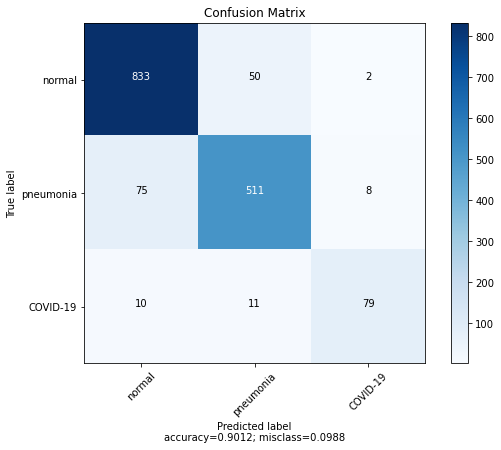

In [10]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(temp, result)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

# Plot normalized confusion matrix
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = list(test_generator.mapping.keys()),
                      title        = "Confusion Matrix")